In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/FakeNewsDetector"
!ls

/content/drive/MyDrive/Colab Notebooks/FakeNewsDetector
 all_data.xls	    lime_bilstm_explanation.html   NNlime_example.html
 BERT.ipynb	    lime_lstm_explanation.html	   Preprocess_data.ipynb
 Bi-LSTM.ipynb	   'Logistic Regression.ipynb'	   unzip_data.ipynb
 FakeNewsNet	    LSTM.ipynb			   WELFake_data
 FakeNewsNet.zip   'Naive Bayes.ipynb'		   WELFake_data.zip
 Interpretibility   NN.ipynb


In [3]:
!pip install -q transformers datasets

In [3]:
import tensorflow as tf
import numpy as np
from transformers import BertTokenizerFast, TFBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

In [87]:
#Pytorch BERT
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments

Load Tokenizer

In [5]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 163182f6-540b-4a7c-9a7b-090b0aeb3ac4)')' thrown while requesting GET https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt
Retrying in 1s [Retry 1/5].


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Load and Tokenize text

In [11]:
df = pd.read_csv("WELFake_data/WELFake_data_clean.csv", keep_default_na=False, na_filter=False)
df.head()

,title,text,label,title_text,text_length
0,law enforcement high alert following threats c...,comment expected barack obama members fyf fuky...,1,law enforcement high alert following threats c...,3179
1,unbelievable obamas attorney general says char...,demonstrators gathered last night exercising c...,1,unbelievable obamas attorney general says char...,161
2,bobby jindal raised hindu uses story christian...,dozen politically active pastors came private ...,0,bobby jindal raised hindu uses story christian...,5543
3,satan russia unvelis image terrifying new supe...,rs sarmat missile dubbed satan replace ss flie...,1,satan russia unvelis image terrifying new supe...,1327
4,time christian group sues amazon splc designat...,say one time someone sued southern poverty law...,1,time christian group sues amazon splc designat...,1093


In [12]:
# Split data
X = df['title']
y = df['label']

#data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Prepare data

In [17]:
X_train = X_train.astype(str).tolist()
X_test = X_test.astype(str).tolist()
y_train = y_train.astype(int).tolist()
y_test = y_test.astype(int).tolist()

Tokenizer

In [18]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(
    X_train,
    truncation=True,
    padding=True,
    max_length=128
)

test_encodings = tokenizer(
    X_test,
    truncation=True,
    padding=True,
    max_length=128
)

Dataset class

In [19]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, y_train)
test_dataset = NewsDataset(test_encodings, y_test)

Load Model

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Training Arguments

In [22]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    report_to="none"
)

Evaluation

In [23]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

Trainer

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

Train

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.222700,0.207695,0.921023,0.922411
2,0.152100,0.236102,0.930179,0.931552
3,0.078800,0.308184,0.934582,0.936144


TrainOutput(global_step=10731, training_loss=0.16447789550616307, metrics={'train_runtime': 2076.2404, 'train_samples_per_second': 82.691, 'train_steps_per_second': 5.168, 'total_flos': 5028997309396020.0, 'train_loss': 0.16447789550616307, 'epoch': 3.0})

Evaluate

In [26]:
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      7006
           1       0.93      0.94      0.94      7302

    accuracy                           0.93     14308
   macro avg       0.93      0.93      0.93     14308
weighted avg       0.93      0.93      0.93     14308



In [27]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[6511  495]
 [ 441 6861]]


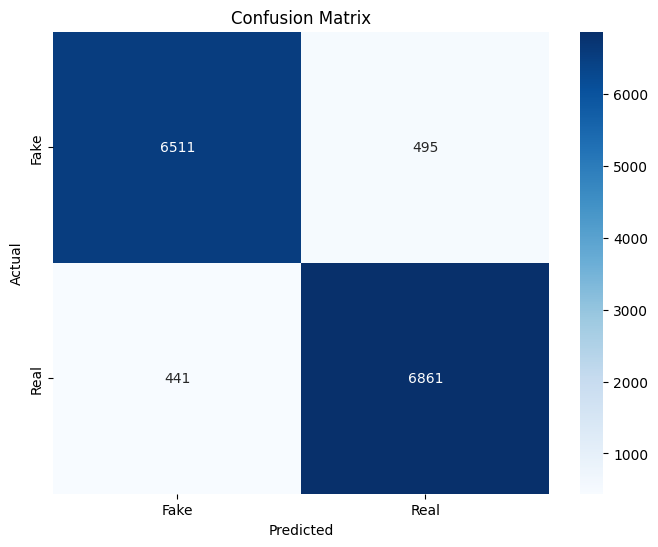

In [28]:
# Confusion matrix visualization
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Exploring Interpretibility with SHAP

In [29]:
!pip install shap


Predicting Function

In [30]:
import torch

def predict_proba(texts):
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)

    return probs.cpu().numpy()


In [41]:
#SHAP explainer, Creating a pipeline
from transformers import pipeline
import shap

clf = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True
)


Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [39]:
print(type(X_test[10]))

<class 'str'>


In [42]:
#SHAP explainer
explainer = shap.Explainer(clf)

In [56]:
i = 10
texts_to_explain = [X_test[i]]  # list of str

shap_values = explainer(texts_to_explain)
html = shap.plots.text(shap_values[0], display=True)



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.89s/it]               


In [58]:
shap_html = shap.plots.text(shap_values[0], display=False)

with open("Interpretibility/11shap_explanation_BERT_title.html", "w", encoding="utf-8") as f:
    f.write(shap_html)


In [49]:
sv.values.shape

(29, 2)

In [50]:
shap_vals_class1 = sv.values[:, 1]   # for REAL class

In [51]:
import pandas as pd

df_explain = pd.DataFrame({
    "token": sv.data,
    "shap_value": shap_vals_class1
}).sort_values(by="shap_value", ascending=False)

df_explain.head(15)

,token,shap_value
17,chuck,0.028281
2,takes,0.014473
5,animal,0.001331
4,send,0.001156
15,rid,0.000683
12,starting,0.000352
13,process,0.000335
14,get,0.000263
27,video,0.000220
22,lottery,0.000213


Modeling with Title and Text

In [59]:
# Split data
X = df['title_text']
y = df['label']

#data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Prepare data

In [60]:
X_train = X_train.astype(str).tolist()
X_test = X_test.astype(str).tolist()
y_train = y_train.astype(int).tolist()
y_test = y_test.astype(int).tolist()

Tokenize

In [61]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(
    X_train,
    truncation=True,
    padding=True,
    max_length=128
)

test_encodings = tokenizer(
    X_test,
    truncation=True,
    padding=True,
    max_length=128
)

Dataset class

In [62]:
train_dataset = NewsDataset(train_encodings, y_train)
test_dataset = NewsDataset(test_encodings, y_test)

Load Model

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Taining Argument

In [64]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    report_to="none"
)

Evaluation

In [65]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

Trainer

In [66]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

Train

In [68]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1
1,0.070100,0.053353,0.093300,0.985183,0.985525
2,0.043300,0.058987,0.093300,0.987490,0.987799
3,0.010100,0.064784,0.093300,0.989027,0.989275


TrainOutput(global_step=10731, training_loss=0.05324436449380259, metrics={'train_runtime': 4309.9354, 'train_samples_per_second': 39.835, 'train_steps_per_second': 2.49, 'total_flos': 1.129318694039808e+16, 'train_loss': 0.05324436449380259, 'epoch': 3.0})

Evaluation

In [69]:
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7006
           1       0.99      0.99      0.99      7302

    accuracy                           0.99     14308
   macro avg       0.99      0.99      0.99     14308
weighted avg       0.99      0.99      0.99     14308



In [70]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[6910   96]
 [  61 7241]]


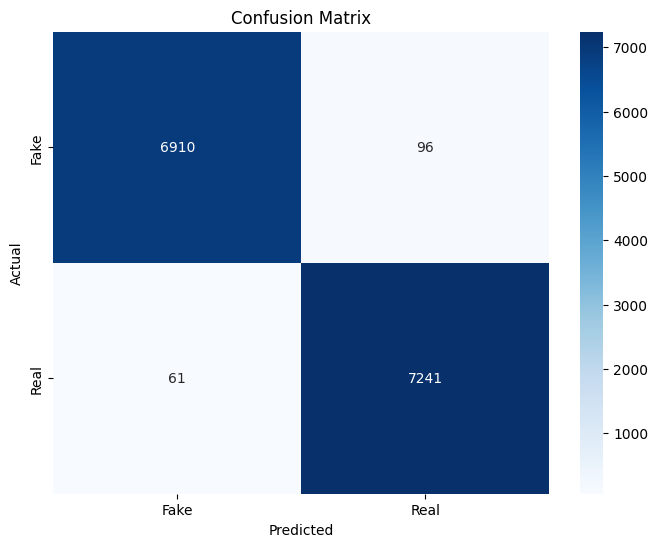

In [71]:
# Confusion matrix visualization
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Interpretibility

In [72]:
print(type(X_test[10]))

<class 'str'>


In [73]:
#SHAP explainer
explainer = shap.Explainer(clf)

In [74]:
i = 10
texts_to_explain = [X_test[i]]  # list of str

shap_values = explainer(texts_to_explain)
html = shap.plots.text(shap_values[0], display=True)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:10, 10.46s/it]               


In [75]:
shap_html = shap.plots.text(shap_values[0], display=False)

with open("Interpretibility/12shap_explanation_BERT_title_text.html", "w", encoding="utf-8") as f:
    f.write(shap_html)

In [76]:
sv = shap_values[0]
sv.shape

(269, 2)

In [77]:
shap_vals_class1 = sv.values[:, 1]   # for Real class

In [78]:
df_explain = pd.DataFrame({
    "token": sv.data,
    "shap_value": shap_vals_class1
}).sort_values(by="shap_value", ascending=False)

df_explain.head(15)

,token,shap_value
59,ironically,0.000015
238,humane,0.000011
239,ly,0.000011
240,enemy,0.000008
28,president,0.000008
27,video,0.000008
241,combat,0.000007
242,ant,0.000007
46,confirmed,0.000007
77,gi,0.000007


Conclusion

In [84]:
#BERT with training only the title f1 - 0.93
#BERT with training title and text combined f1 - 0.99

In [85]:
#No doubt the best performance has been achieved by slightly fine tuning BERT model